# Filtrage des composés similaires aux candidats
Objectif : A partir des composés trouvés sur la base de données PubChem, filtrer ces composés sur la base de leurs caractéristiques physico-chimiques et leur respect de la règle de Lipinski.

## Prérequis

In [32]:
!pip install rdkit &> /dev/null

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import pandas as pd

import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
import matplotlib.pyplot as plt

from pickle import load
from os import chdir
chdir("/content/drive/MyDrive/Colab Notebooks/these_exercice/src")

from tqdm import tqdm

from rdkit import RDLogger , Chem
from rdkit.Chem import Descriptors, MolFromSmiles   
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
# Désactivation des xarnings de rdkit
RDLogger.DisableLog('rdApp.*')    

In [35]:
import fct.molecularFiltering as molFilter

In [36]:
def find_properties(listSmiles, function) :
    fun = function
    molProp = []
    for i in tqdm(range(len(listSmiles))) :
        mol = molecules[i]
        try :
            molProp.append(fun(MolFromSmiles(mol)))
        except :
            molProp.append(None)
    return(molProp)

## Importation des molécules récupérées

In [37]:
# Récupération de l'identifiant uniprot
with open("../output/01_compoundDataAcquisition/uniprot_id.txt", "rb") as file:
    uniprot_id = load(file)
print(uniprot_id)
# Chargement des données
molecules = pd.read_csv("../output/05_findSimilarCompounfPubChem/processedIds_" + uniprot_id + ".csv", header=None)
# Supression de la première colonne
molecules = molecules.drop(0, axis=1)
# Conversion de l'ensemble des colonnes en un dataframe ave une seule colonne : smiles
molecules = [item for i in molecules.values for item in i]
# Supression des doublons
molecules = list(set(molecules))
print(len(molecules))

P08581
73505


## Calcul des propriétés physico-chimiques

In [38]:
print("Computing molecular weight")
molecules_molecular_weight = find_properties(molecules, Descriptors.ExactMolWt)
print("HBA")
molecules_n_hba = find_properties(molecules, Descriptors.NumHAcceptors)
print("HBD")
molecules_n_hbd = find_properties(molecules, Descriptors.NumHDonors)
print("LogP")
molecules_logp = find_properties(molecules, Descriptors.MolLogP)
# Create a dataframe
molecules = pd.DataFrame(list(zip(molecules, 
                                  molecules_molecular_weight, 
                                  molecules_n_hba, 
                                  molecules_n_hbd, 
                                  molecules_logp)),
                         columns=["smiles","molecular_weight","n_hba","n_hbd","logp"])
# Supression des données manquantes
molecules = molecules.dropna()
print("Compute Lipinski rule")
molecules["lipinski"] = molecules.smiles.apply(molFilter.calculate_ro5_properties)

Computing molecular weight


100%|██████████| 73505/73505 [00:21<00:00, 3418.85it/s]


HBA


100%|██████████| 73505/73505 [00:17<00:00, 4288.90it/s]


HBD


100%|██████████| 73505/73505 [00:13<00:00, 5546.39it/s]


LogP


100%|██████████| 73505/73505 [00:39<00:00, 1878.87it/s]


Compute Lipinski rule


In [39]:
# Restriction des molécules à celles respectant la règle de Lipinski
molecules = molecules[molecules["lipinski"]]
print(f"{molecules.shape[0]} molecules follows Lipinski rules")

66816 molecules follows Lipinski rules


## Radar plot

In [40]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Mol. weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

In [41]:
molecules_stats = molFilter.calculate_mean_std(
    molecules[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)

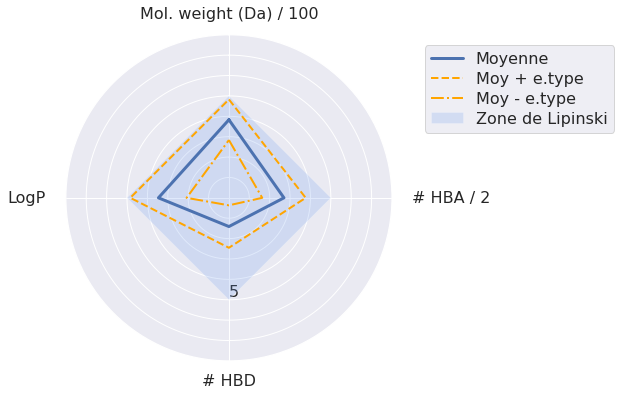

In [42]:
molFilter.plot_radar(
    molecules_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
    output_path = "../output/06_similarCompoundMolecularFiltering/"
)

## Filtre sur la présence de motifs sur-intéragissant, générateurs de bruit

In [43]:
# initialisation du filtre
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [44]:
#molecules.set_index("smiles", inplace = True)
molecules.head()

,smiles,molecular_weight,n_hba,n_hbd,logp,lipinski
1,C1COCCN1CCCCC(=O)NC2=CC=C(C=C2)C3=CN=CC=C3.Cl,375.171355,4.0,1.0,3.6114,True
2,C1CCC(CC1)CCC(C(=O)N)NC(=O)C2=CC=C(C=C2)CNC(=O...,502.269239,6.0,4.0,3.3287,True
3,C1CC1C2=CC(=NN2)NC3=NC(=NC=C3)NC4=CC5=C(C=C4)N...,332.149793,6.0,4.0,3.4406,True
4,CN1C=C(C=N1)C2=C3C4=CC=CC=C4C(C3=CC(=C2)C(=O)N...,443.145676,5.0,2.0,2.9300,True
5,CS(=O)(=O)CCN1C=CC2=C1C=CC=C2OC3=NC=NC(=C3)CN,346.109961,7.0,1.0,1.7269,True


In [45]:
""" 
On ne garde que les molécules sans motifs
intéragissant avec toute sorte de protéines
""" 

matches = []
clean = []
for index, row in tqdm(molecules.iterrows(), total=molecules.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "smiles": row.smiles,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
moleculesData = molecules.loc[clean]  


100%|██████████| 66816/66816 [04:03<00:00, 274.82it/s]


In [46]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(moleculesData)}")

Number of compounds with PAINS: 2929
Number of compounds without PAINS: 63887


## Filtre sur la présence de motifs indésirables



In [47]:
# Chargement des sous-structures non désirées
substructures = pd.read_csv("../input/unwantedCompounds.csv", sep=";")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 101


In [48]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(moleculesData.iterrows(), total=moleculesData.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "smiles": row.smiles,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
moleculesData = moleculesData.loc[clean]

100%|██████████| 63887/63887 [07:54<00:00, 134.58it/s]


In [49]:
# Vérification du nombres de molécules sans sous structures non voules
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(moleculesData)}")

Number of found unwanted substructure: 14835
Number of compounds without unwanted substructure: 53129


In [50]:
moleculesData.shape

(53129, 6)

## Enregistrement des données

In [51]:
moleculesData.to_csv("../output/06_similarCompoundMolecularFiltering/"+uniprot_id+"_ro5Compliant.csv",
                               index=False)